In [1]:
from pathlib import Path
import sys

ROOT = Path.cwd()
if (ROOT / "src").exists() is False and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent

sys.path.insert(0, str(ROOT))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from src.viz import *
from statsmodels.tsa.deterministic import DeterministicProcess

Data part

In [3]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

store_sales = pd.read_csv(
    ROOT / "Data/train.csv",
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)

In [4]:
store_sales['date'] = pd.to_datetime(store_sales['date'])
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr','family'],append = True)

In [5]:
average_sales = store_sales.groupby('date').mean()['sales']
average_sales.head(10)

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
2013-01-06    291.636017
2013-01-07    188.621109
2013-01-08    178.646347
2013-01-09    169.770370
2013-01-10    145.332214
Freq: D, Name: sales, dtype: float32

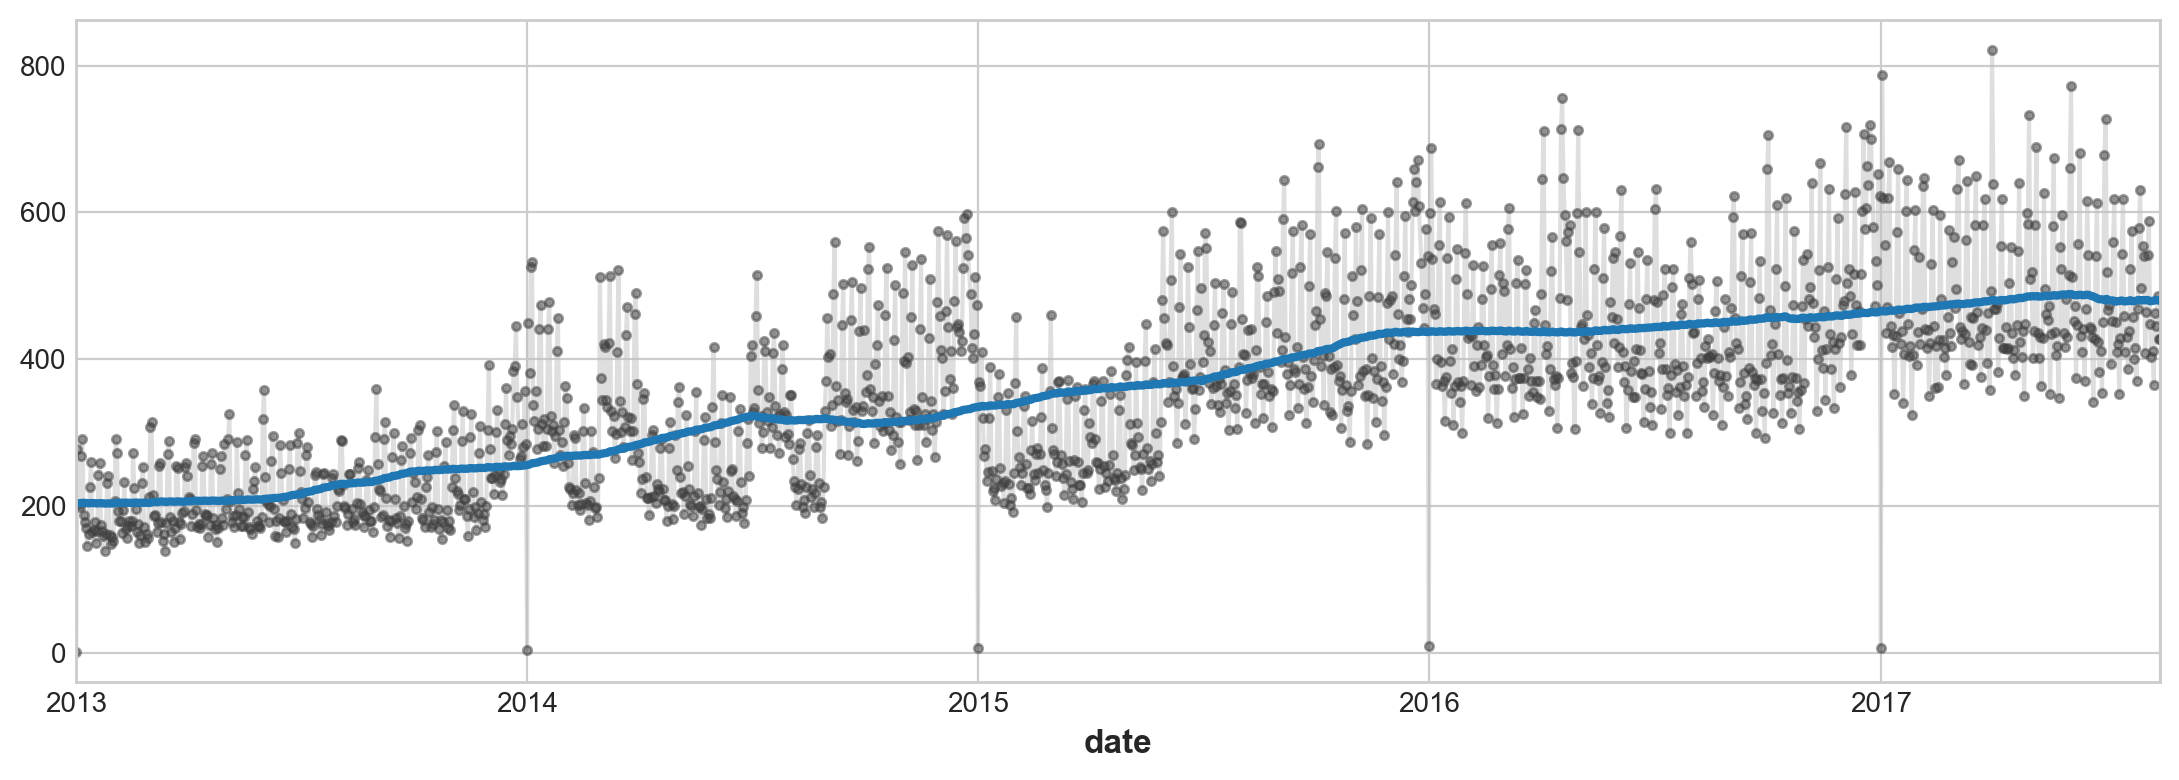

In [6]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [7]:
y = average_sales.copy()

dp = DeterministicProcess(
    index = y.index,
    constant = True,
    order = 2,
    drop = True,
)

X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)
X.head()

,const,trend,trend_squared
date,,,
2013-01-01,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0
2013-01-03,1.0,3.0,9.0
2013-01-04,1.0,4.0,16.0
2013-01-05,1.0,5.0,25.0


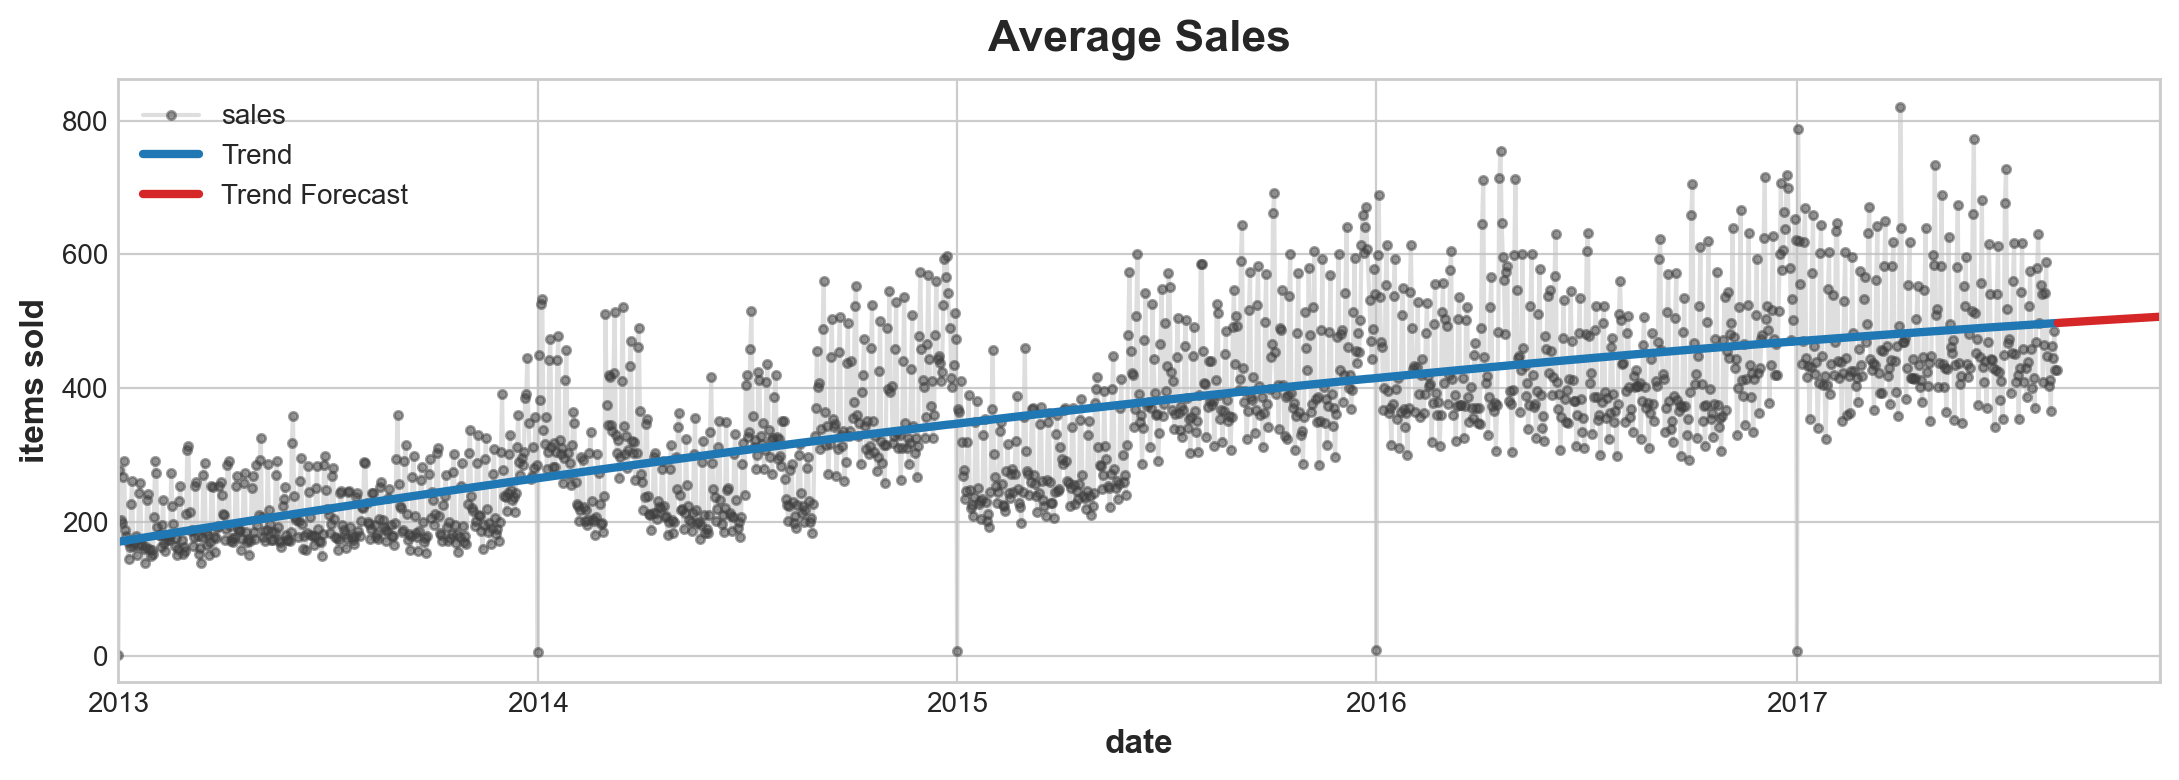

In [8]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()